# Solving the Longest Path Problem

In this notebook, we will describe how to solve the **Longest Path** problem with LunaSolve. We will begin by defining, explaining and giving an example for the Longest Path problem. We will then continue by modeling a problem instance, optimize it and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [A Real World Example](#2)
3. [Solving the Longest Path problem with Luna](#3)

## **Longest Path Problem**

The **Longest Path** problem is a well-known combinatorial optimization challenge in graph theory and computer science. The task is to find the longest possible path between a specified start and end node in a graph $ G $, without visiting any vertex more than once.

The length of a path can be measured in two ways: by the number of edges (in unweighted graphs) or by the sum of edge weights (in weighted graphs).

Formally, given a graph $ G = (V, E) $, where $ V = \{ v_1, v_2, \ldots, v_n \} $ is the set of vertices, $ E $ is the set of edges, and $ v_s $ and $ v_e $ are the designated start and end vertices. A longest path in $ G $ is a sequence of vertices $(v_{p(1)}, v_{p(2)}, \ldots)$ such that:

1. The total number of edges (or total weight, in a weighted graph) along the path is maximized.
2. Every pair of consecutive vertices in the sequence is connected by an edge: $(v_{p(i)}, v_{p(i+1)}) \in E$.
3. The first and last vertices in the sequence are $ v_s $ and $ v_e $, respectively.

<a id="2"></a>
## 2. Description of a Real World Example

One key use case of the Longest Path problem is in scheduling and planning, especially in project management, where tasks often depend on one another.

In such settings, tasks are represented as vertices, and dependencies are represented as directed edges. The edge weights can correspond to task durations. The longest path through this network reveals the critical path, the sequence of tasks that determines the minimum time required to complete the entire project. Delays in any task on the critical path will delay the whole project.

Let’s walk through an example project:

**Tasks**: A, B, C, D, E  
**Durations**:
- A: 2 days
- B: 4 days
- C: 3 days
- D: 2 days
- E: 5 days

**Dependencies (Edges)**:
- A must be completed before B and C can start.
- B and C must both finish before D can start.
- D must be completed before E begins.

In this case, A is the starting task and E is the final task. The graph structure captures task relationships and durations as edge weights. By finding the longest path from A to E, we identify the critical path of the project.

<a id="3"></a>
## 3. Solving the Longest Path problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna_quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna_quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Longest Path problem using LunaSolve. First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [18]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Create a Longest Path problem

To create a `LongestPath` instance, any graph with vertices and edges is sufficient. In this notebook, we will create one representing the task dependencies and their order. Each task is a node of the graph. A connection between the nodes symbolizes a dependency between the two tasks and the length of the edge the total duration.

After defining the graph, we will visualize it for better comprehension.

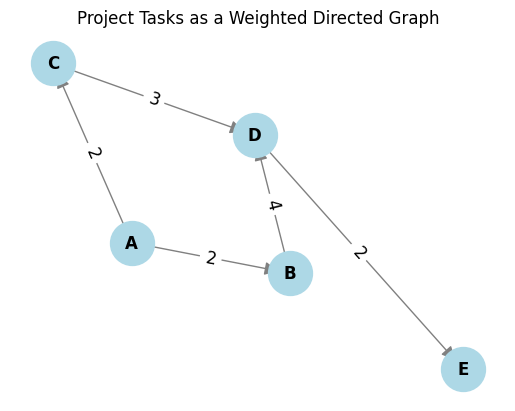

In [20]:
# Import the necessary packages
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
longest_path_graph = nx.DiGraph()

# Define and add nodes of the graph that represent the tasks
tasks = ["A", "B", "C", "D", "E"]
longest_path_graph.add_nodes_from(tasks)

# Define and add the edges (dependencies bteween tasks) with weights equal to the duration of the starting task
edges = [
    ("A", "B", 2),
    ("A", "C", 2),
    ("B", "D", 4),
    ("C", "D", 3),
    ("D", "E", 2)
]
for u, v, w in edges:
    longest_path_graph.add_edge(u, v, weight=w)

# Set all edges to the default color first (for the visualization of the solution)
for edge in longest_path_graph.edges:
    longest_path_graph[edge[0]][edge[1]]['color'] = 'gray'

# Draw the Graph
pos = nx.spring_layout(longest_path_graph, seed=42)

nx.draw_networkx_nodes(longest_path_graph, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_edges(longest_path_graph, pos, edge_color='gray', arrows=True, arrowsize=20)
nx.draw_networkx_labels(longest_path_graph, pos, font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(longest_path_graph, 'weight')
nx.draw_networkx_edge_labels(longest_path_graph, pos, edge_labels=edge_labels, font_size=12)
plt.title("Project Tasks as a Weighted Directed Graph")
plt.axis('off')
plt.show()


### 3.3 Defining a Longest Path Object

The graph we created now represents our tasks. To find the longest path, and with that also the critical path, using LunaSolve, we define the Longest Path use case using Luna’s `LongestPath` class. This class converts the problem instance into an optimization problem, which Luna can then optimize.

When initializing a `LongestPath` instance, ensure you pass the graph as a dictionary using NetworkX's `nx.to_dict_of_dicts()` method. Additionally, a `start_node` and `ènd_node` (first and final tasks) must be passed together with the maximal number of `steps` along the path. Optionally, you can provide a descriptive `name` for your instance—if not specified, LunaSolve defaults it to `LP` for LongestPath.

In [21]:
# Import the LongestPath object from the luna sdk
from luna_quantum.solve.use_cases import LongestPath

# Create a LongestPath object, to use within the luna_sdk for optimisation
longest_path = LongestPath(graph=nx.to_dict_of_dicts(longest_path_graph), start_node="A", terminal_node="E", steps=7)

### 3.4 Uploading the use case model to Luna 

Now, let's upload our Longest Path problem to Luna. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization. 

In [22]:
# Initiliaze the optimization object using the created use case instance
model = ls.model.create_from_use_case(name="Longest Path", use_case=longest_path)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. In order to successfully create a job, we must first select an algorithm from LunaSolve's collection for the optimization, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Longest Path problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are only going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we execute the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name`for the job for easy identification.

In [23]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model, name="Longest-Path with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution` object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

In the case of the Longest Path problem, the `representation` is returned as a list of tuples, where each tuple provides two pieces of information. The node in the graph (represented as a list containing the node name), and the step number (or turn) in which the node is visited along the path. You can think of this as a timeline or a sequence that shows which node is visited when in the longest path found by the solver. The order of the list already gives you the correct sequence of nodes in the path—from start to end.

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [ ]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

In order to better grasp the solution, we can visualize the graph we created, and colour all edges included in the longest path in order to see the longest path over the total graph.

In [ ]:
# Set all edges to the default color first
for edge in longest_path_graph.edges:
    longest_path_graph[edge[0]][edge[1]]['color'] = 'gray'
    
# Color each edge that connects two consecutive nodes in the chosen Longest Path
path = best_use_case_result["solution"]
for node_1, node_2 in zip(path[:-1], path[1:]):
    c_1, c_2 = node_1[0][0], node_2[0][0]
    print(f"c_1: {c_1}, c_2: {c_2}")
    longest_path_graph[c_1][c_2]['color'] = 'green'

# Draw the graph with the updated edge colors
edge_colors = [longest_path_graph[edge[0]][edge[1]]['color'] for edge in longest_path_graph.edges]
nx.draw_networkx_nodes(longest_path_graph, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_labels(longest_path_graph, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(longest_path_graph, pos, width=2, edge_color=edge_colors)
plt.title("Critical Path of Project")
plt.axis('off')
plt.show()

Congrats! You have now solved the Set Partitioning problem using the use case library of Luna! If you are interested in finding out more about the plethora of different use cases Luna provides, we encourage you to explore the use case library!